### Imports 

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Silence tensorflow alerts
import tensorflow as tf

In [4]:
import sys
path_to_software_folder = sys.path[0][:-23] + 'software/'
sys.path.append(path_to_software_folder) # Add the software folder to path, note that outside of the "demo" folder you will need to manually set "path_to_software_folder"
from DoubleWell import DoubleWell
from ProcessingNets import *
from Network_Passive import *
from FlowRES_MCMC_Passive import *
from Plotting import *

# Define the model

In [5]:
start_point = [-1.0, 0]
duration = 1.6
traj_len = 32
D_t = 0.15
mu = 0.1
dt = duration/traj_len
tran_coeff = np.sqrt(2*D_t*dt)
pot_coeff = mu*dt

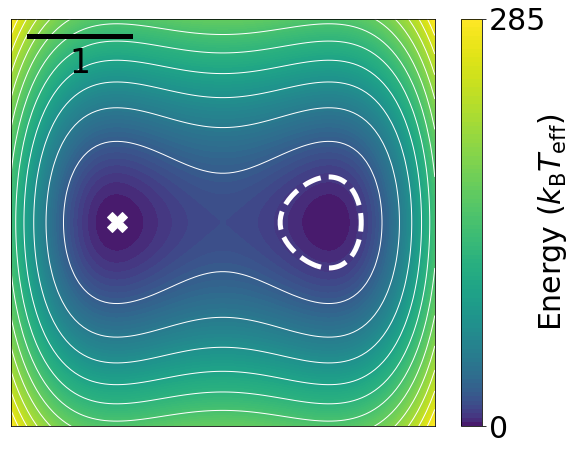

In [30]:
params = {'x_0' :  1.0,
          'k_x' :  2.0,
          'k_y' :  10.0,
          'k_BH' : 15,
          'target': 7.5}
Double_Well = DoubleWell(params=params)
Double_Well.plot_energy_surface_DW()

# Create a network

In [7]:
Affine_Wave_params = {'num_filters': 32,
                      'kernel_size': 3,
                      'num_dilated_conv_layers': 3}

Num_Layers = 2    # number of scales
FLOWS_pre_LAYER = 1    # For passive, leave this as 1
Pos_flows_per_Flow = 10    # Number of complete positional flow steps

Ang_flows_per_Flow = 0.00    # Leave this as 0
CCs = 0.00    # For passive, leave this as 0
Pos_CC_per_Flow = 0.00    # For passive, leave this as 0
Ang_CC_per_Flow = 0.00    # Leave this as 0, this term lets positions affect angles

Net = CreateFlowNet(Num_Layers, FLOWS_pre_LAYER,
                    Pos_flows_per_Flow, Ang_flows_per_Flow, 
                    CCs, Pos_CC_per_Flow, Ang_CC_per_Flow,
                    Affine_WaveNet=Wave_unit, Affine_WaveParams=Affine_Wave_params, 
                    potential_grad=Double_Well.batch_gradient,
                    start=start_point, tran_coeff=tran_coeff, pot_coeff=pot_coeff,
                    max_len=traj_len, dim=3)

... creating network
Network created.


# Explore Using FlowRES

In [8]:
num_chains = 30000
num_iterations = 100

FlowRES_Passive_DoubleWell = FlowRes_MCMC(Net, num_chains, Chain_Initialiser_Passive, Double_Well)    # define the FlowRES framework for this system
FlowRES_Passive_DoubleWell.Compile_ML_Model(batch_size=512, lr=0.001)    # compile the network so that it is ready to train    

all_FlowRES_hists = FlowRES_Passive_DoubleWell.Explore(iterations=num_iterations, return_hists=True, hist_bins=np.linspace(-2,2,200))[0]

Iteration 1 / 100


/home/cs-solomon.asghar/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    accepted 81.72666666666667% of non-local proposals
Train on 24623 samples
24623/24623 [==============================] - 34s 1ms/sample - loss: 31.5312

    network trained with non-local samples
Iteration 2 / 100
    accepted 50.839999999999996% of non-local proposals
Train on 29057 samples
29057/29057 [==============================] - 16s 561us/sample - loss: 29.1497

    network trained with non-local samples
Iteration 3 / 100
    accepted 43.53666666666667% of non-local proposals
Train on 29859 samples
29859/29859 [==============================] - 17s 563us/sample - loss: 26.2830

    network trained with non-local samples
Iteration 4 / 100
    accepted 39.65% of non-local proposals
Train on 29979 samples
29979/29979 [==============================] - 17s 561us/sample - loss: 23.9819

    network trained with non-local samples
Iteration 5 / 100
    accepted 43.266666666666666% of non-local proposals
Train on 30000 samples
30000/30000 [==============================] - 17s 560

# Compare FlowRES to Direct Integration

In [9]:
# Load in Direct Integration data for comparison
Validation_histogram = np.load(sys.path[0] + '/Direct_Integration_Data/Validation_histogram.npy')    # load a histogram generated from 10000 direct integration paths
Direct_integration_histogram = np.load(sys.path[0] + '/Direct_Integration_Data/Direct_integration_histogram.npy')    # load a histogram generated from 50000 direct integration paths
Direct_Integration_JSD_vs_Proposals = np.load(sys.path[0] + '/Direct_Integration_Data/Direct_Integration_JSD_vs_Proposals.npy')    # load a JSD with validation ensemble against proposal number for direct integration

## Plot JSDs with Validation Ensemble

In [16]:
bins = np.linspace(-2,2,200)
all_FlowRES_JSDs = np.zeros(num_iterations+1)

for i, FlowRES_histogram in enumerate(all_FlowRES_hists):    # plot a histogram for the FlowRES ensemble at each iteration and work out its JSD from the validation histogram
    all_FlowRES_JSDs[i] = JSD(FlowRES_histogram, Validation_histogram)
    
Num_Paths_Proposed_FlowRES = num_chains * np.arange(num_iterations+1)
FlowRES_JSD_vs_Proposals = np.stack([Num_Paths_Proposed_FlowRES, all_FlowRES_JSDs])

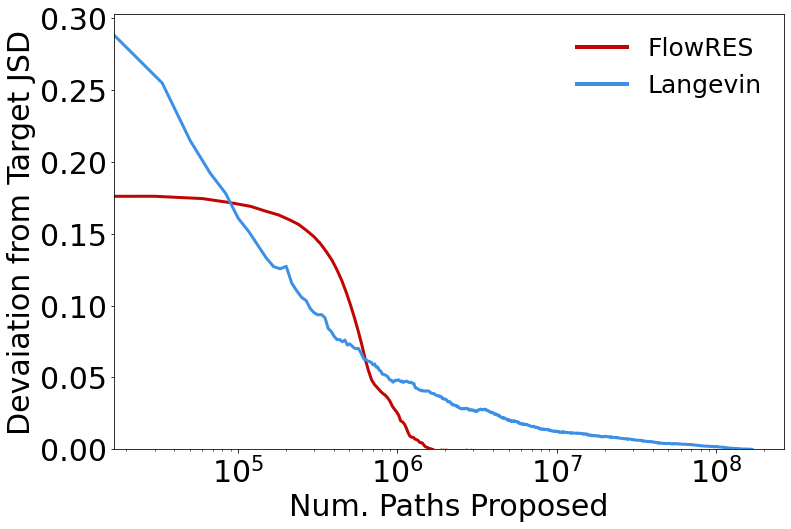

In [36]:
compare_JSDS(FlowRES_JSD_vs_Proposals, Direct_Integration_JSD_vs_Proposals)

## FlowRES and Direct Integration Histograms

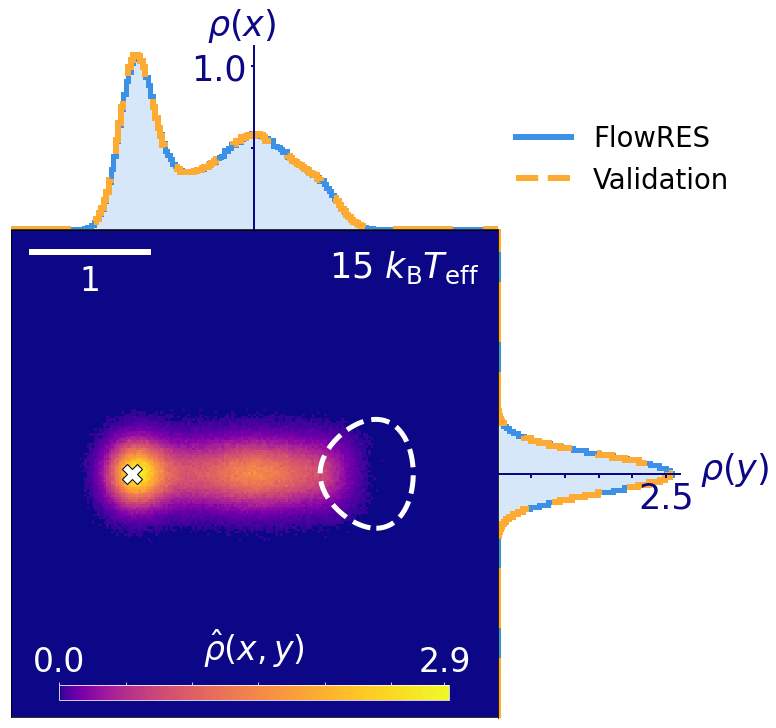

In [34]:
# plot histograms
Compare_Hists(FlowRES_histogram, Validation_histogram, bins, Double_Well,
              text=str(params['k_BH']) + r'$\ k_{\rm B} T_{\rm eff}$')